# Algorithm 3 from Neal (2000)

Implementation of the algorithm 3 form Neal (2000). With a Normal-Inverse-Wishart prior. The computation of the integral is obtained from Murphy (2007) (https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_t
from scipy.stats import entropy
import random
import copy
from tqdm import tqdm

## 1. Functions for our assumptions

Define function to compute likelihood of some observation belonging to a given cluster given our assumptions

In [2]:
# These functions change based on assumption on the prior parameters of the model
def compute_mu_0(Y):
    return np.mean(Y, axis=0)   # default to mean of data, reasonable assumption

def compute_nu_0(D):
    return D    # default to D, potentially change this

def compute_inv_scale_mat_0(D):
    return np.eye(D)    # default to identity, potentially change this

def compute_lamb_0(Y):
    return 1    # default to 1, potentially change this


def integral_func_1(Y, cluster, i):
    """
    Compute the first integral using student_t distribution based on Murphy (2007) parameters
    """
    D = len(Y[0])
    mu_0 = compute_mu_0(Y)
    lamb_0 = compute_lamb_0(Y)
    nu_0 = compute_nu_0(D)
    inv_scale_mat_0 = compute_inv_scale_mat_0(D)
    n = len(cluster)    # number of element currently in cluster (used n to be consistent with Murphy (2007) notation)
    
    cluster_Y = Y[np.isin(np.arange(len(Y)),cluster)]
    cluster_mean = np.mean(cluster_Y, axis=0)

    # based on Murphy (2007). These should not be changed
    mu_n = (lamb_0 * mu_0 + n * cluster_mean) / (lamb_0 + n)
    lamb_n = lamb_0 + n
    nu_n = nu_0 + n
    
     # compute scatter matrix
    S = np.zeros((D,D))
    for j in range(n):
        temp = Y[j] - cluster_mean
        S += np.outer(temp, temp)
    temp = cluster_mean - mu_0
    inv_scale_mat_n = inv_scale_mat_0 + S + ((lamb_0 * n) / (lamb_0 + n)) * np.outer(temp, temp)

    # Computes integral using pdf of student t
    student_df = nu_n - D + 1
    integral = multivariate_t.pdf(Y[i],
                                  mu_n,
                                  inv_scale_mat_n * ((lamb_n+1) / (lamb_n * student_df)),
                                  student_df)
    return integral

def integral_func_2(Y, i):
    """
    Computes the second integral using student_t distribution based on Murphy (2007) parameters.
    """
    D = len(Y[0])
    mu_0 = compute_mu_0(Y)
    lamb_0 = compute_lamb_0(Y)
    nu_0 = compute_nu_0(D)
    inv_scale_mat_0 = compute_inv_scale_mat_0(D)
    student_df = nu_0 - D + 1
    # Computes integral using pdf of student t
    integral = multivariate_t.pdf(Y[i],
                                  mu_0,
                                  inv_scale_mat_0 * ((lamb_0 + 1) / (lamb_0 * student_df)),
                                  student_df)
    return integral

## 2. Functions for Algorithm 3

In [3]:
def compute_entropy(labels, base=None):
  counts = []
  for cluster in labels:
    counts.append(len(cluster))
  return entropy(counts, base=base)

def cluster_probabilities(i, clusters, Y, integral_func_1, integral_func_2, alpha):
    """
    Computes the probabilities of observation i joining each clusters or creating a new one. The output is not sctictly probabilities but weights.
    """
    n = len(Y)
    n_clusters = len(clusters)
    probabilities = np.zeros(n_clusters+1)

    # probabilities of joining existing cluster
    for c in range(n_clusters):
        probabilities[c] = integral_func_1(Y, clusters[c], i)
        probabilities[c] *= (len(clusters[c]) / (n - 1 + alpha))

    # probability of creating new cluster
    probabilities[-1] = integral_func_2(Y, i)
    probabilities[-1] *= alpha / (n - 1 + alpha)

    return probabilities

def algorithm_3(n_steps, Y, integral_func_1, integral_func_2, alpha=1, plot_traceplots=True):
    """
    Performs a markov chain using algorithm 3 from Neal (2000). 

    Args:
        n_steps: int, number of step of the markov chain to do (one step is defined as randomly moving each observation 1 time)
        Y: 2D array, of observations. Each observation is a vetor of size D. So Y is of shape (n_observation, D)
        integral_func_1: function to compute the first integral in (3.7). Takes as argument the current observations in a cluster and the new observation.
        integral_func_2: function to compute the second integral in (3.7). Takes as argument the only observation of the new cluster
        alpha: float, concentration parameter. alpha > 0
        plot_traceplots: boolean to have traceplots
    """
    D = len(Y[0])
    n_obs = len(Y)

    clusters = [[i] for i in range(n_obs)]

    history = [copy.deepcopy(clusters)]
    entropies = [compute_entropy(clusters)]

    # Initialize progress bar
    progress_bar = tqdm(total=n_steps, desc="Markov Chain Progress", unit="step")

    for step in range(n_steps):  # Markov chain
        for i in range(n_obs):  # 1 step of the Markov chain
            # 1. Find in which cluster the observation is
            c = 0
            for index in range(len(clusters)):  # one step 
                if i in clusters[index]:
                    c = index
                    break
            # 2. Remove observation i from clusters:
            if len(clusters[c]) == 1:  # case 1: i is the only element of the cluster -> remove cluster
                del clusters[c]
            else:  # case 2: cluster has more than 1 element -> remove i from the cluster
                clusters[c].remove(i)

            # 3. Compute probabilities of adding i to each cluster
            weights = cluster_probabilities(i, clusters, Y, integral_func_1, integral_func_2, alpha)
            transitions = list(range(len(weights)))
            transition = random.choices(transitions, weights=weights)[0]

            # 4. Apply transition 
            if transition == len(clusters):  # add new cluster
                clusters.append([i])
            else:
                clusters[transition].append(i)

        # All elements have moved once -> one step of the Markov chain
        history.append(copy.deepcopy(clusters))
        entropies.append(compute_entropy(clusters))

        # Update progress bar
        progress_bar.update(1)

    # Close progress bar
    progress_bar.close()
    
    if plot_traceplots == True:
        plt.plot(entropies)
        plt.title("Traceplot")
        plt.xlabel("Iteration")
        plt.ylabel("Entropy")

    return history, entropies

## 3. Test with synthetic data

Generate and visualize synthethic data

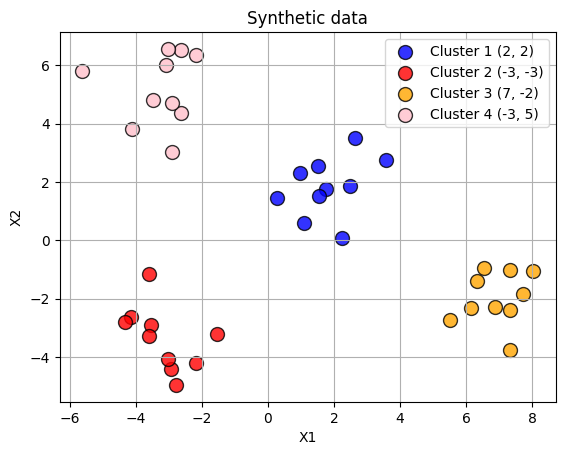

In [4]:
# Sample syntethic
np.random.seed(42)  # for reproducibility
random.seed(42)

mean1 = [2, 2]
cov1 = np.eye(2)
data1 = np.random.multivariate_normal(mean1, cov1, size=10)

mean2 = [-3, -3]
cov2 = np.eye(2)  # Matrice identità (covarianza)
data2 = np.random.multivariate_normal(mean2, cov2, size=10)

mean3 = [7, -2]
cov3 = np.eye(2)
data3 = np.random.multivariate_normal(mean3, cov3, size=10)

mean4 = [-3, 5]
cov4 = np.eye(2)  # Matrice identità (covarianza)
data4 = np.random.multivariate_normal(mean4, cov4, size=10)

data = np.vstack((data1, data2, data3, data4))

import matplotlib.pyplot as plt

plt.scatter(data1[:, 0], 
            data1[:, 1], 
            label="Cluster 1 (2, 2)", 
            color="blue",
            s = 100,
            alpha=0.8, edgecolor="k")
plt.scatter(data2[:, 0], 
            data2[:, 1], 
            label="Cluster 2 (-3, -3)", 
            color="red",
            s = 100,
            alpha=0.8, edgecolor="k")
plt.scatter(data3[:, 0], 
            data3[:, 1], 
            label="Cluster 3 (7, -2)", 
            color="orange",
            s = 100,
            alpha=0.8, edgecolor="k")
plt.scatter(data4[:, 0], 
            data4[:, 1], 
            label="Cluster 4 (-3, 5)", 
            color="pink",
            s = 100,
            alpha=0.8, edgecolor="k")
plt.legend()
plt.title("Synthetic data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid()
plt.show()

Apply algorithm 3 on synthetic data and visualize result

Markov Chain Progress:   0%|          | 0/2500 [00:00<?, ?step/s]

Markov Chain Progress: 100%|██████████| 2500/2500 [06:16<00:00,  6.63step/s]


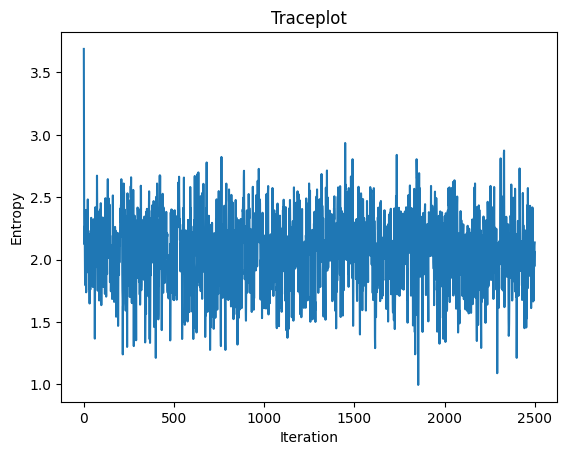

In [5]:
# these can be modified
n_steps = 2500
burn_in = 500
alpha = 10
history, entropies = algorithm_3(n_steps, 
                                data, 
                                integral_func_1, 
                                integral_func_2,
                                alpha=alpha)
clusters = history[-1]

In [8]:
def sampled_sim_matrix(MC_part, n_obs):
    """
    Compute A, the similarity matrix of dimensions n_obs * n_obs, where A[i,j] is the frequency for which the observations
    i and j are assigned to the same cluster.

    Args:
        MC_part: list of lists, MCMC sampling of partitions. Each partition is a list of clusters, 
                 and each cluster is a list of observation indices.
        n_obs: int, total number of observations.

    Returns:
        A: np.ndarray, similarity matrix of size (n_obs, n_obs).
    """
    
    A = np.zeros((n_obs, n_obs), dtype=float)
    n_sample = len(MC_part)

    for clusters in MC_part:
        for cluster in clusters:
            for i in cluster:
                for j in cluster:
                    if i != j:  # Avoid double increment for diagonal
                        A[i, j] += 1

    # Normalize by the number of samples
    A /= n_sample

    # Ensure the diagonal is 1 (observations are always in the same cluster with themselves)
    np.fill_diagonal(A, 1.0)

    return A

In [9]:
M = sampled_sim_matrix(history[burn_in:], len(data))

/tmp/ipykernel_5358/486091085.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(dist_matrix, method='complete')


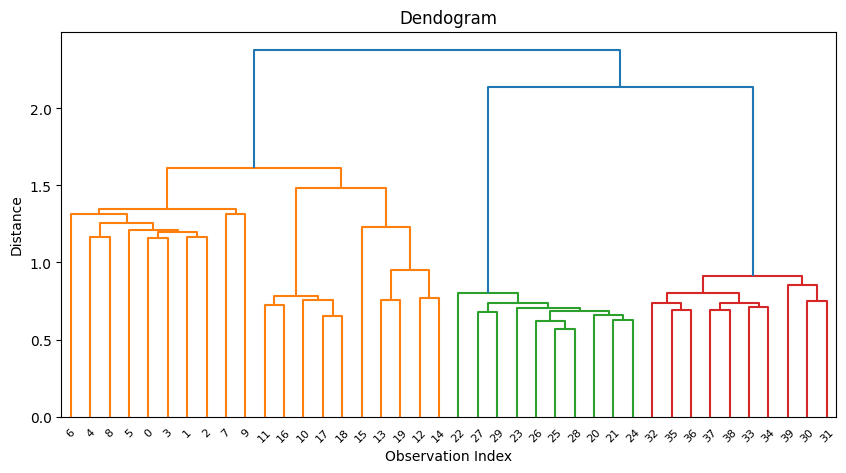

In [10]:
import scipy.cluster.hierarchy as sch

dist_matrix = 1 - M

Z = sch.linkage(dist_matrix, method='complete')

plt.figure(figsize=(10, 5))
sch.dendrogram(Z)
plt.title("Dendogram")
plt.xlabel("Observation Index")
plt.ylabel("Distance")
plt.show()

In [12]:
t = 1.5
final_cluster = sch.fcluster(Z, t, criterion='distance', depth=2, R=None, monocrit=None)

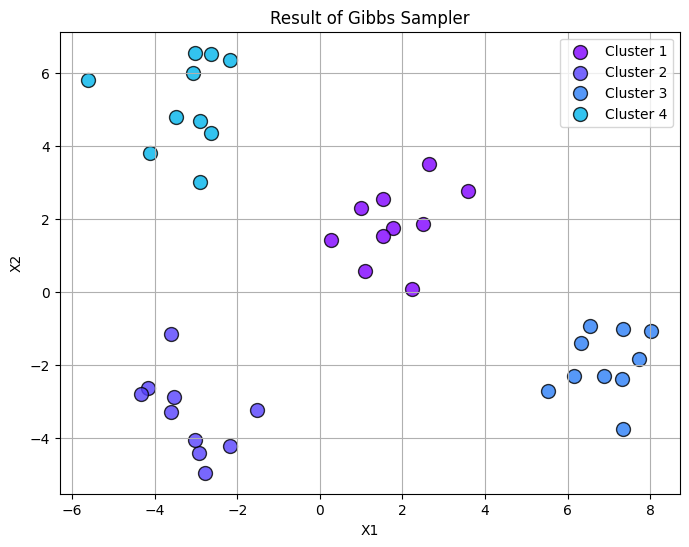

In [13]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

plt.figure(figsize=(8, 6)) 

for cluster_id in np.unique(final_cluster):
    cluster_mask = final_cluster == cluster_id
    plt.scatter(
        data[cluster_mask, 0],
        data[cluster_mask, 1],
        label=f"Cluster {cluster_id}",
        color=colors[cluster_id - 1],
        s=100,
        alpha=0.8,
        edgecolor="k"
    )

# Add labels, legend, and grid
plt.title("Result of Gibbs Sampler")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid()
plt.show()